<a href="https://colab.research.google.com/github/mdehghani86/RL_labs/blob/master/Lab%202/Lab_2(a)_MABs_Binomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2-a: Multi-armed Bandits Problem (Binomial)
<sub>Prof. Dehghani</sub>


---

## 1. Problem definition: k-armed bandits

You repeatedly choose among $k$ actions. After each choice you receive a numerical reward drawn from a stationary distribution that depends on the chosen action. The objective is to maximize the expected total reward over many time steps.

Let the action at time step $t$ be $A_t$ and the reward be $R_t$.  
The true value of action $a$ is

$$
q_*(a) = \mathbb{E}[R_t \mid A_t = a]
$$

We estimate these values by $Q_t(a)$.

- **Exploitation**: choosing the action with the largest estimate  
- **Exploration**: trying other actions  

A common method is **$\varepsilon$-greedy**:

- with probability $1-\varepsilon$, select  
  $$
  A_t = \arg\max_a Q_t(a)
  $$
- with probability $\varepsilon$, select a random action  

> In this lab we simulate the k-armed bandit with **stationary rewards**  
> (the reward distributions do not change over time).

---

## 2. Implementation of the 10-arm testbed

To compare greedy and $\varepsilon$-greedy methods, we use a standard **10-arm testbed**:

- $k = 10$ actions  
- True action values $q_*(a)$, $a=1,\dots,10$, are sampled from $\mathcal{N}(0,1)$  
- When action $A_t$ is chosen, the reward is  
  $$
  R_t \sim \mathcal{N}(q_*(A_t),\,1)
  $$  

This setup allows us to measure and compare strategies.

---

## Importing Libraries

- **NumPy** — random normal generation, means, vector ops  
- **Matplotlib** — charts and figures


### 1. Calculating and displaying true rewards: k-armed bandit (Binomial, Stationary)

In this section we demonstrate the reward distribution for the **10-armed testbed** under stationary rewards.  
We generate the true rewards for each arm using a **binomial distribution**, ensuring all values are non-negative.  

---

### Plotting the rewards

We use **matplotlib** to visualize the expected rewards of the 10 arms,  
with each arm shown as a bar and labeled with its value.


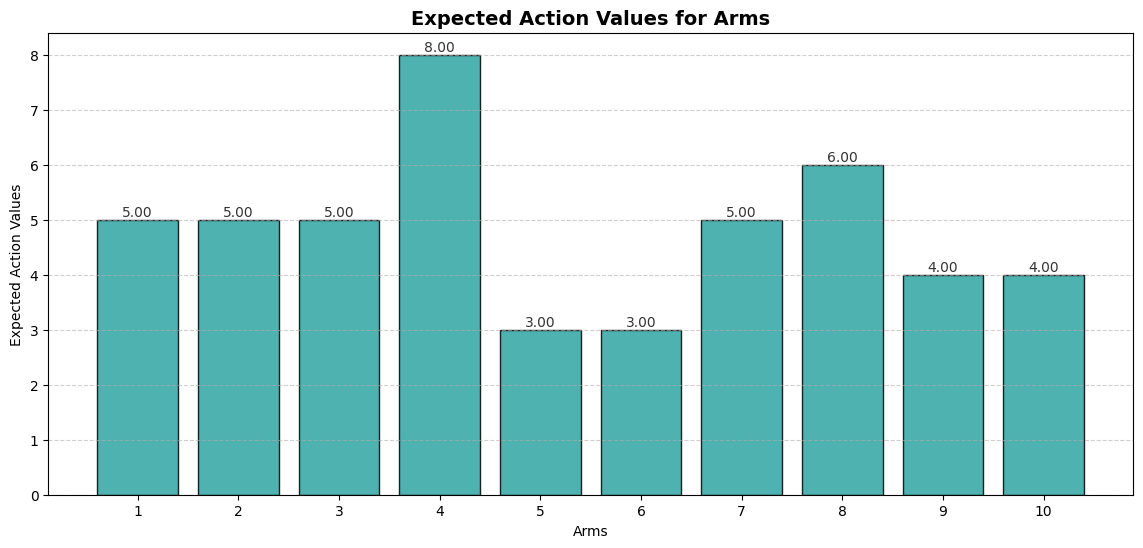

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Example Data: Binomial rewards (always non-negative)
# ----------------------------
arms = 10
# Each arm has an expected reward drawn from a binomial distribution.
# For example: 10 trials with p=0.5 gives expected values between 0 and 10.
expected_action_value = np.random.binomial(n=10, p=0.5, size=arms)

# ----------------------------
# Define Sutto-inspired colors
# ----------------------------
sutto_colors = ["#2fa5a3", "#7cc7c3", "#f06d3d"]  # teal, aqua, orange

# ----------------------------
# Create Figure and Axes
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 6))

x_pos = np.arange(1, arms+1)

# ----------------------------
# Plot Bars
# ----------------------------
bars = ax.bar(x_pos, expected_action_value,
              align="center",
              color=sutto_colors[0],  # teal
              edgecolor="black",
              alpha=0.85)

# ----------------------------
# Customize Plot Appearance
# ----------------------------
ax.set_title("Expected Action Values for Arms", fontsize=14, fontweight="bold")
ax.set_xlabel("Arms")
ax.set_ylabel("Expected Action Values")
plt.xticks(x_pos, x_pos)

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle="--", alpha=0.6)

# ----------------------------
# Add Data Labels
# ----------------------------
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f"{height:.2f}",
            ha="center", va="bottom", fontsize=10, color="#333")

# ----------------------------
# Show Plot
# ----------------------------
plt.show()


### Reward function

---

Given an action taken, this method randomly return $-1$ or $0$ as the reward corresponding to that action.

In [2]:
def reward_function(action_taken, expected_action_value):
    # Simulate reward for chosen arm
    # If random ≤ success probability → reward = 1, else 0
    if np.random.uniform(0, 1) <= expected_action_value[action_taken]:
        return 1
    else:
        return 0


### Methods 1:  <span style="color:blue">$\epsilon-greedy$</span>  function

---
Given a epsilon value ($e$), this function determines whether the algorithm should go for `exploitation` or `exploration`.

If $e$ is greater than a randomly generated value, it chooses exploration, else it chooses exploitation.

In [3]:
# Define the ε-greedy function
def e_greedy(estimate_action_value, e, arms):
    # Draw random number in [0,1] to compare with ε
    e_estimator = np.random.uniform(0, 1)

    # With probability (1-ε) choose best action, else explore randomly
    action = np.argmax(estimate_action_value) if e_estimator > e else np.random.choice(np.arange(arms))

    return action


### Action Value estimation, Method 1 -  <span style="color:blue">Sample Average approach</span>
---
Given an action, number of times the action is taken, this function estimates the action value.

To simplify notation, we concentrate on a single action. Let $R_i$  denote the reward received after the $i$th selection of this action, and let $Q_n$ denote the estimate of its action value after it has been selected $n−1$ times, which we can now write simply as

$Q_n \dot= \frac{R_1+R_2+R_3+...+R_{n-1}}{n-1}$

This equation mentioned above can be refactored as follows

$Q_{n+1} = Q_n + \frac{1}{n} [R_n - Q_n ]$ ... (2.3)
**bold text**
That is,

$NewEstimate \leftarrow OldEstimate + StepSize[Target - OldEstimate]$

This function replicates the equation (2.3) mentioned above.


In [4]:
# Define estimate_action_value function (using sample average method)
def sample_average (estimate_action_value, action, reward, count):
    estimate_action_value[action] = estimate_action_value[action] + (1/(count[action]+1))\
        * (reward - estimate_action_value[action])
    return estimate_action_value

### The k-armed bandits function

---

This function simulates the k-armed bandits problem base don the given inputs, including the  `number of arms`, `number of steps`, `epsilon`, and `expected action values`. Then, the function runs the problem for 'number of steps' times and returns the the `overall reward` and `optimal action`corresponding to each step.

The function uses `sample average` to update for stationary reward estimation.

In [5]:
def multi_arm_bandit_problem(arms = 10, steps = 1000, e = 0.1, expected_action_value = [] ):
    # Initilization
    overall_reward, optimal_action = [], []
    estimate_action_value = np.zeros(arms) # Initial estimate of action values is set to zero
    count = np.zeros(arms) #number of times the action (arm) is taken

    # Main loop
    for s in range(0, steps):

        # Select an action
        action=e_greedy(estimate_action_value,e, arms)

        # Observe the reward for the selected Action
        reward = reward_function(action, expected_action_value)

        # Update Estimates of Action Value for the selected Action based on its observed Reward
        estimate_action_value=sample_average(estimate_action_value, action, reward, count)

        # Update rewards' list
        overall_reward.append(reward)

        # If the optimal action is taken
        optimal_action.append(action == np.argmax(expected_action_value))

        # Increment the number of times the selected action is takern
        count[action] += 1

    return overall_reward, optimal_action

### Multi-arm testbed

---

This function creates the k-arm bandit test bed which runs each bandit problem with 1000 steps, for 2000 times. The number of times the bandit problem runs, is captured in the variable run, as mentioned above.

In [6]:
# The k-armed bandits testbed
def run_game(epsilon, runs=5000, steps=1000, arms=10):
    # Store rewards and optimal-action indicators across runs
    rewards = np.zeros((runs, steps))
    optimal_actions = np.zeros((runs, steps))

    # Initialize true action values (stationary, uniform in [0,1])
    expected_action_value = np.random.uniform(0, 1, arms)

    # Repeat experiment for the given number of runs
    for run in range(runs):
        rewards[run][:], optimal_actions[run][:] = multi_arm_bandit_problem(
            arms=arms,
            steps=steps,
            e=epsilon,
            expected_action_value=expected_action_value
        )

    # Average results across runs
    rewards_avg = np.average(rewards, axis=0)
    optimal_action_perc = np.average(optimal_actions, axis=0)

    return rewards_avg, optimal_action_perc


### Plotting the reward performance and optimal action percentage of the scenarios with different epsilon values.


---

Here we are using the testbed function `run_game`created above to generate the reward performance and the optimal action percentage graph for the agents with different epsilons

1. scenario with epsilon value of 0.0: Blue
2. scenario with epsilon value of 0.01 : Orange
3. scenario with epsilon value of 0.1 : green

In [7]:
# Initialize Parameters

# Number of arms of bandits.
arms=10

# Numner of episodes in each run
steps = 1000

# Total number of runs
runs = 2000

# Different values of epsilon
Epsilons=[0.0, 0.01, 0.1]

In [8]:
# Running the Experiment with different Epsilon Values
rewards_avg_by_epsilon = dict()
optimal_action_perc_by_epsilon = dict()
for epsilon in Epsilons :
    print('Running for epsilon {}'.format(epsilon))
    rewards_avg, optimal_action_perc = run_game(epsilon, runs=runs, steps=steps, arms=arms)
    rewards_avg_by_epsilon[epsilon] = rewards_avg
    optimal_action_perc_by_epsilon[epsilon] = optimal_action_perc

print('Experiment is complete!!')


Running for epsilon 0.0
Running for epsilon 0.01
Running for epsilon 0.1
Experiment is complete!!


Once we have the reward performance and optimal action from the test bed, we can now plot the graphs using the in-built function `plot` of matplotlib.

## Conclusion

In this lab we implemented and analyzed the **k-armed bandit problem** using the $\varepsilon$-greedy strategy.  
Key takeaways:  

- The **binomial testbed** provided non-negative, stationary rewards.  
- $\varepsilon$-greedy balances **exploration** and **exploitation**.  
- Different values of $\varepsilon$ change both **average rewards** and the **percentage of optimal actions** over time.  
- Visualization with Sutto-inspired colors highlighted performance across strategies.  

This experiment demonstrates how simple policies can significantly affect learning outcomes in reinforcement learning.


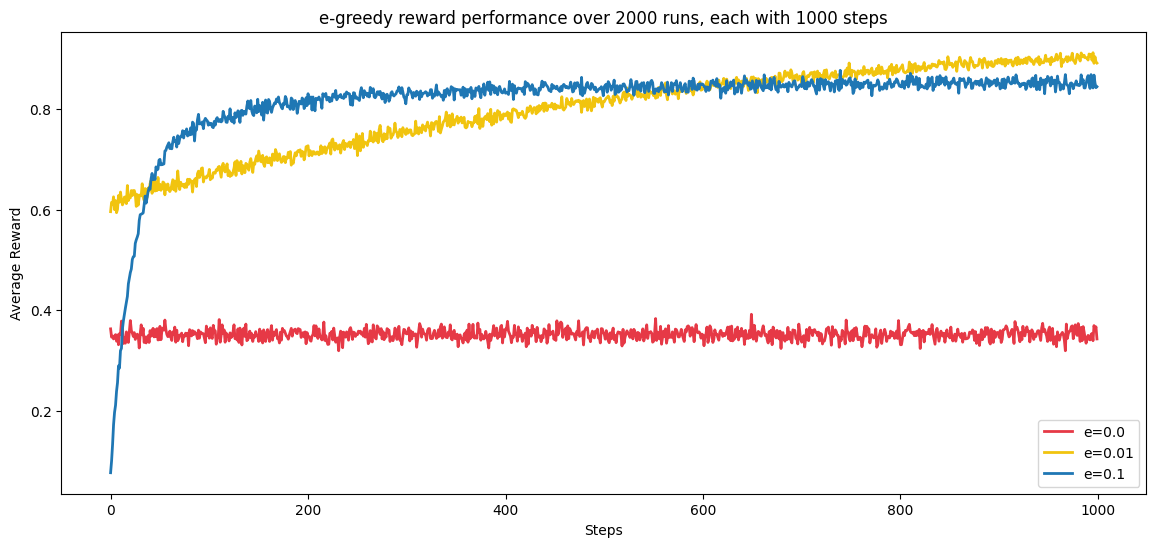

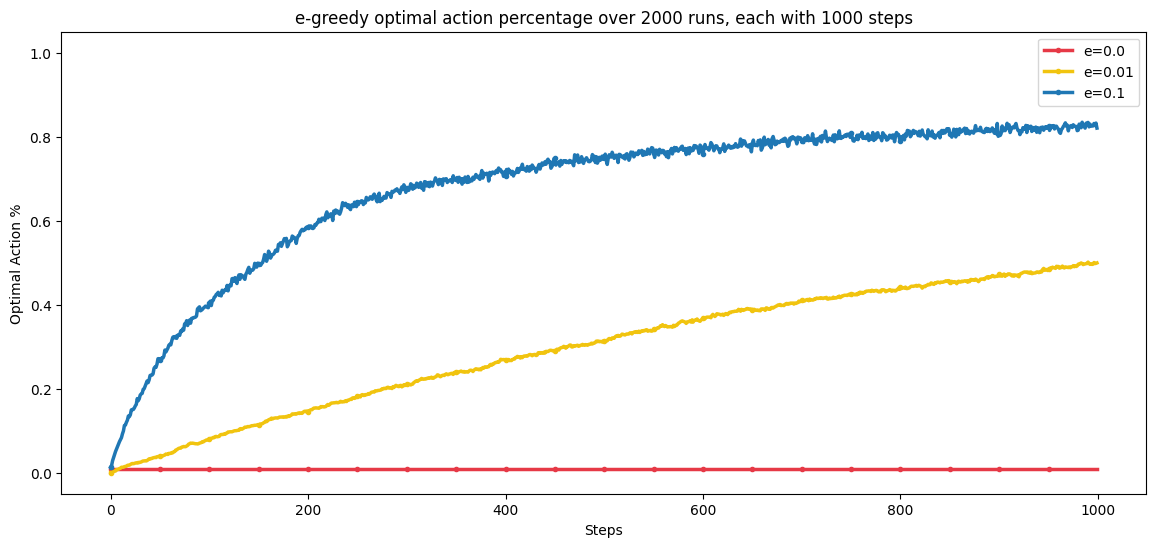

In [9]:
# Colors extracted directly from the image
image_colors = [
    "#e63946",  # red
    "#f1c40f",  # yellow
    "#1f77b4",  # blue
    "#f06d3d",  # orange
    "#000000"   # black
]

# --- First Plot: Average Reward ---
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
for i, epsilon in enumerate(Epsilons):
    ax.plot(range(steps),
            rewards_avg_by_epsilon[epsilon],
            label=f"e={epsilon}",
            color=image_colors[i % len(image_colors)],  # cycle palette
            linewidth=2)

ax.legend(loc='lower right')
plt.title(f'e-greedy reward performance over {runs} runs, each with {steps} steps')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.show()


# --- Second Plot: Optimal Action % (modified) ---
f, ax = plt.subplots(figsize=(14, 6))
for i, epsilon in enumerate(Epsilons):
    y_values = optimal_action_perc_by_epsilon[epsilon]

    # Ensure flat lines at y=0 are visible
    if np.all(y_values == 0):
        y_values = y_values + 0.01

    ax.plot(range(steps),
            y_values,
            label=f"e={epsilon}",
            color=image_colors[i % len(image_colors)],  # cycle palette
            linewidth=2.5,
            marker="o", markersize=3, markevery=steps//20)  # markers for visibility

ax.legend()
plt.title(f'e-greedy optimal action percentage over {runs} runs, each with {steps} steps')
plt.xlabel('Steps')
plt.ylabel('Optimal Action %')
ax.set_ylim(-0.05, 1.05)  # padding so 0% and 100% lines are visible
plt.show()
